In [1]:
import pandas as pd
apple_csv = pd.read_csv('Apple.csv')
amazon_csv = pd.read_csv('Amazon.csv')
google_csv = pd.read_csv('Google.csv')
micro_csv = pd.read_csv('Microsoft.csv')
netflix_csv = pd.read_csv('Netflix.csv')

apple_csv.columns = [f'Apple_{col}' if col != 'Date' else 'Date' for col in apple_csv.columns]
amazon_csv.columns = [f'Amazon_{col}' if col != 'Date' else 'Date' for col in amazon_csv.columns]
google_csv.columns = [f'Google_{col}' if col != 'Date' else 'Date' for col in google_csv.columns]
micro_csv.columns = [f'Microsoft_{col}' if col != 'Date' else 'Date' for col in micro_csv.columns]
netflix_csv.columns = [f'Netflix_{col}' if col != 'Date' else 'Date' for col in netflix_csv.columns]

merged_df = apple_csv
merged_df = pd.merge(merged_df, amazon_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, google_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, micro_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, netflix_csv, on='Date', how='outer')

# converts to proper 
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
columns_without_date = merged_df.drop(columns=['Date']).columns.tolist()
merged_df[columns_without_date] = merged_df[columns_without_date].apply(pd.to_numeric, errors='coerce')

# remove rows with missing vals
merged_df.dropna(inplace=True)

# makes date as key
merged_df.set_index('Date', inplace=True)

# removes and duplicate rows
merged_df.drop_duplicates(inplace=True)

# extracts only the years we want
df = merged_df[500:2150]
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Apple_Open,Apple_High,Apple_Low,Apple_Close,Apple_Adj Close,Apple_Volume,Amazon_Open,Amazon_High,Amazon_Low,...,Microsoft_Low,Microsoft_Close,Microsoft_Adj Close,Microsoft_Volume,Netflix_Open,Netflix_High,Netflix_Low,Netflix_Close,Netflix_Adj Close,Netflix_Volume
0,2006-08-14,2.287500,2.329286,2.271429,2.283571,1.943590,717620400,1.3110,1.3530,1.3090,...,24.350000,24.530001,17.597080,47831900,2.842857,2.858571,2.834286,2.844286,2.844286,5253500.0
1,2006-08-15,2.333571,2.375000,2.314286,2.373214,2.019886,861352800,1.3485,1.3930,1.3310,...,24.440001,24.620001,17.726677,48994500,2.862857,2.900000,2.830000,2.850000,2.850000,6462400.0
2,2006-08-16,2.396429,2.431071,2.368929,2.427857,2.066394,781284000,1.3985,1.4070,1.3760,...,24.469999,24.700001,17.784285,52373600,2.860000,2.877143,2.795714,2.824286,2.824286,10453800.0
3,2006-08-17,2.428571,2.452143,2.399286,2.413929,2.054539,581148400,1.3980,1.4875,1.3915,...,24.610001,24.700001,17.784285,45674800,2.800000,2.951429,2.798571,2.861429,2.861429,9569700.0
4,2006-08-18,2.418214,2.442857,2.402143,2.425357,2.064267,536354000,1.4545,1.4615,1.4110,...,24.980000,25.790001,18.569094,128414800,2.871429,2.890000,2.824286,2.835714,2.835714,5793900.0


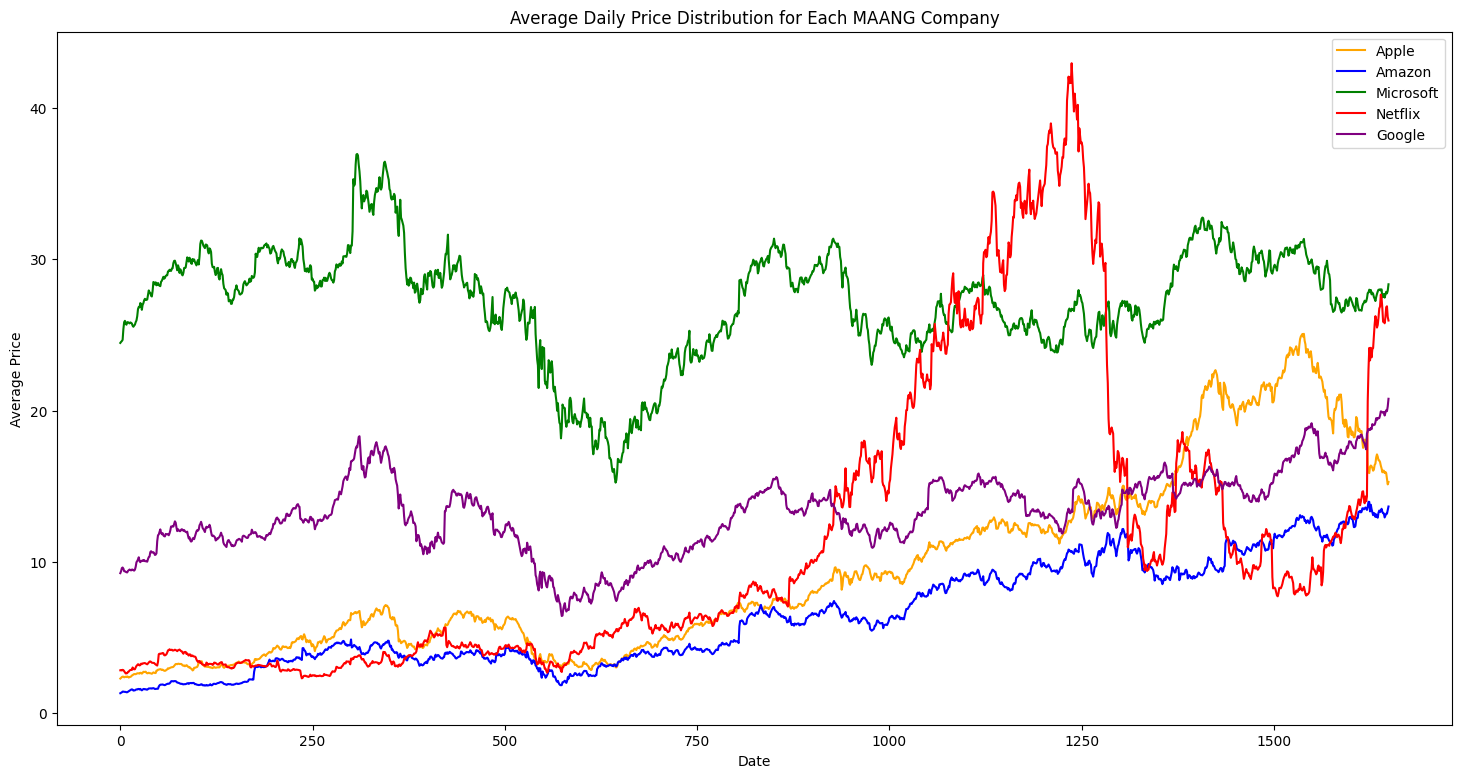

In [2]:
# Line Plot
import matplotlib.pyplot as plt

# dict of companies to line colors
companies = {
    'Apple': 'orange',
    'Amazon': 'blue',
    'Microsoft': 'green',
    'Netflix': 'red',
    'Google': 'purple'
}

# iterates and extracts the company averages per day
for company in companies.keys():
    df[f'{company}_Avg'] = (df[f'{company}_High'] + df[f'{company}_Low']) / 2

# plots the indv company average distributions
plt.figure(figsize=(18, 9))
for company, color in companies.items():
    plt.plot(df.index, df[f'{company}_Avg'], label=company, color=color)

# label and title
plt.title('Average Daily Price Distribution for Each MAANG Company')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [24]:
# Creating the line plot in D3 instead
df.to_csv('maang_data.csv', index=True)

In [3]:
# Area Graph for Total Monthly Volume
import altair as alt

volume_cols = ['Apple_Volume', 'Amazon_Volume', 'Google_Volume', 'Microsoft_Volume', 'Netflix_Volume']

# New dataframe with only monthly total volume for each company per year
# REFERENCE https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
df_monthly = df.groupby(pd.Grouper(key='Date', freq='ME')).sum()[volume_cols].reset_index()

# Selection element
selection = alt.selection_point(fields = ['Company'])

color = alt.condition(
    selection,
    alt.Color('Company:N', scale=alt.Scale(domain=volume_cols, range=list(companies.values()))).legend(None),
    alt.value(None)
)

# Area Graph
area = alt.Chart(df_monthly).transform_fold(
    volume_cols, 
    as_=['Company', 'Volume']
).mark_area(opacity=0.6).encode(
    alt.X('yearmonth(Date):T', title='Year & Month', axis=alt.Axis(format='%Y-%b')),
    alt.Y('Volume:Q', title='Total Volume of Shares', stack=None),
    color = color
).properties(
    title='Total Monthly Volume of Shares Per MAANG Company',
    width=800,
    height=400
).add_params(
    selection  
)

# Interactive Legend
legend = alt.Chart(df_monthly).transform_fold(
    volume_cols, 
    as_=['Company', 'Volume']
).mark_rect().encode(
    alt.Y('Company:N', axis=alt.Axis(orient='right')),  # Correctly reference the Company field
    color=color  # Apply the color condition to the legend as well
).add_params(
    selection
)

area | legend

alt.HConcatChart(...)

In [4]:
# Data pre-processing for google search trends data
trends = pd.read_csv('trends.csv')

# Filtering for the US between 2006 and 2013
trends = trends[(trends['location'] == 'United States') & (trends['year'].isin(range(2006, 2014)))]
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)
trends
# checking what categories exist
# print(trends['category'].unique())
# Scandals, Lawsuits, Presidential Campaign, It's the Economy, Google.com Fastest Falling, Google Maps Searches, Google News Searches, Google.com Fastest Rising, Donate To, News Searches, Product Searches, Searches, Economy, Gadgets, Political Scandals, Politics, Technology, Election Issues, Stocks, Tech Gadgets, US Politicians, Events, New York City, NY

,location,year,category,rank,query
540,United States,2006,Movie Showtimes,1,Idiocracy Showtimes
541,United States,2006,Movie Showtimes,2,Cars Showtimes
542,United States,2006,Movie Showtimes,3,Borat Showtimes
543,United States,2006,Movie Showtimes,4,Superman Showtimes
544,United States,2006,Movie Showtimes,5,Jesus Camp Showtimes
545,United States,2006,Scandals,1,Duke Lacrosse Scandal
546,United States,2006,Scandals,2,Project Runway Scandal
547,United States,2006,Scandals,3,Duke Scandal
548,United States,2006,Scandals,4,Duke Rape Scandal
549,United States,2006,Scandals,5,Reggie Bush Scandal


In [12]:
# Top three searches per desired category per year
desired_categories = ["Scandals", "Lawsuits", "Presidential Campaign", "It's the Economy", "Google.com Fastest Falling", 
                      "Google Maps Searches", "Google News Searches", "Google.com Fastest Rising", "Donate To", "News Searches", 
                      "Product Searches", "Searches", "Economy", "Gadgets", "Political Scandals", "Politics", "Technology", 
                      "Election Issues", "Stocks", "Tech Gadgets", "US Politicians", "Events", "New York City, NY"]

trends_top = trends[trends['rank'].isin(range(1,4))]
trends_top = trends_top[trends_top['category'].isin(desired_categories)]
trends_top

,location,year,category,rank,query
545,United States,2006,Scandals,1,Duke Lacrosse Scandal
546,United States,2006,Scandals,2,Project Runway Scandal
547,United States,2006,Scandals,3,Duke Scandal
580,United States,2007,Lawsuits,1,Borat Lawsuit
581,United States,2007,Lawsuits,2,Vonage Lawsuit
582,United States,2007,Lawsuits,3,iPhone Lawsuit
590,United States,2007,Presidential Campaign,1,Ron Paul
591,United States,2007,Presidential Campaign,2,Fred Thompson
592,United States,2007,Presidential Campaign,3,Hilary Clinton
1505,United States,2008,It's the Economy,1,Financial Crisis


In [18]:
trends_top['Year'] = trends_top['year']
# Aggregate trends data by year and category to get a count of search entries
trends_summary = trends_top.groupby(['Year', 'category']).size().reset_index(name='search_count')

# Optionally, aggregate by rank to create a weighted score (lower rank = higher impact)
trends_summary['weighted_score'] = trends_top.groupby(['Year', 'category'])['rank'].mean().values
trends_summary.head()

,Year,category,search_count,weighted_score
0,2006,Scandals,3,2.0
1,2007,Lawsuits,3,2.0
2,2007,Presidential Campaign,3,2.0
3,2008,It's the Economy,3,2.0
4,2009,Google.com Fastest Falling,3,2.0


In [40]:
price_cols = ['Apple_High', 'Apple_Low', 'Apple_Close', 
              'Amazon_High', 'Amazon_Low', 'Amazon_Close',
              'Google_High', 'Google_Low', 'Google_Close',
              'Microsoft_High', 'Microsoft_Low', 'Microsoft_Close',
              'Netflix_High', 'Netflix_Low', 'Netflix_Close']

# Dataframe of yearly total volume and average prices
df_yearly_volume = df.groupby(pd.Grouper(key='Date', freq='YE')).sum()[volume_cols].reset_index()
df_yearly_prices = df.groupby(pd.Grouper(key='Date', freq='YE')).mean()[price_cols].reset_index()
df_yearly = pd.merge(df_yearly_volume, df_yearly_prices, on='Date')

# Extract the year from the Date column
df_yearly['Year'] = df_yearly['Date'].dt.year
df_yearly.drop(columns=['Date'], inplace=True)

google_yearly = df_yearly[['Google_Volume', 'Google_High', 'Google_Low', 'Year']]
google_yearly = pd.merge(trends_top, google_yearly, left_on = 'year', right_on = 'Year')
google_yearly.rename(columns = {'query': 'Top_Query'}, inplace = True)

grouped_google = google_yearly.groupby('category').agg('min').reset_index()
grouped_google

,category,location,year,rank,Top_Query,Google_Volume,Google_High,Google_Low,Year
0,Donate To,United States,2011,1,Donate to Japan,3.114476e+10,14.305521,14.037592,2011
1,Economy,United States,2011,1,Debt Ceiling,3.114476e+10,14.305521,14.037592,2011
2,Election Issues,United States,2012,1,Abortion,2.614137e+10,16.146392,15.864414,2012
3,Events,United States,2013,1,Boston Marathon,4.325782e+09,19.137773,18.850848,2013
4,Gadgets,United States,2011,1,Kindle Fire,3.114476e+10,14.305521,14.037592,2011
5,Google Maps Searches,United States,2011,1,IKEA,3.114476e+10,14.305521,14.037592,2011
6,Google News Searches,United States,2011,1,Hurricane Irene,3.114476e+10,14.305521,14.037592,2011
7,Google.com Fastest Falling,United States,2009,1,Heath Ledger,3.550490e+10,11.058242,10.821192,2009
8,Google.com Fastest Rising,United States,2009,1,Facebook,3.550490e+10,11.058242,10.821192,2009
9,It's the Economy,United States,2008,1,Bailout,6.421449e+10,11.814250,11.374182,2008


In [54]:
color_palette = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#a6cee3', '#8B8000']

years_extracted = grouped_google['year'].unique().tolist()
input_radio = alt.binding_radio(
    options= years_extracted,
    name='Select Year'
)
input_var = alt.param(bind=input_radio, value='2006') 
alt.Chart(grouped_google).mark_bar().add_params(input_var).encode(
    alt.Y('Google_High:Q'),
    alt.X('category:N'),
    color = alt.condition(
        alt.datum.year == input_var, 
        alt.Color('Year:N', scale=alt.Scale(domain=years_extracted, range = color_palette)), 
        alt.value('lightgrey')  
    ),
    tooltip=['Top_Query:N', 'year:Q'],
    opacity=alt.condition(input_var, alt.value(1), alt.value(0.1)) 
)

alt.Chart(...)

In [55]:
stock_data = pd.read_csv('Stock Headlines.csv', encoding='ISO-8859-1')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data[['Date', 'Top1', 'Top2', 'Top3']]
data_with_top =pd.merge(df, stock_data, on='Date', how='inner')

In [5]:
import seaborn as sns
from textblob import TextBlob

# Define a function to calculate sentiment score
def sentiment_score(text):
    return TextBlob(text).sentiment.polarity

# Calculate sentiment scores for each Top label
for i in range(1, 4):  # Adjust according to the number of Top labels
    data_with_top[f'Top{i}_Sentiment'] = data_with_top[f'Top{i}'].apply(sentiment_score)


# Calculate average sentiment per day
data_with_top['Average_Sentiment'] = data_with_top[[f'Top{i}_Sentiment' for i in range(1, 4)]].mean(axis=1)

# Calculate daily average sentiment and assign it to a new column
daily_avg_sentiment = data_with_top.groupby('Date')['Average_Sentiment'].transform('mean')

data_with_top

,Date,Apple_Open,Apple_High,Apple_Low,Apple_Close,Apple_Adj Close,Apple_Volume,Amazon_Open,Amazon_High,Amazon_Low,...,Google_Avg,Year,Month,Top1,Top2,Top3,Top1_Sentiment,Top2_Sentiment,Top3_Sentiment,Average_Sentiment
0,2006-08-14,2.287500,2.329286,2.271429,2.283571,1.943590,717620400,1.3110,1.3530,1.3090,...,9.262781,2006,8,"Elektra, Usher Hall, Edinburgh Festival",Athletics: The split in British sprinting that...,"Athletics: Drop the unnecessary theatre, hones...",0.000000e+00,-0.333333,-0.200000,-0.177778
1,2006-08-15,2.333571,2.375000,2.314286,2.373214,2.019886,861352800,1.3485,1.3930,1.3310,...,9.393167,2006,8,Post terror plot are people still so distrustf...,Letters: Answers to Islam's extremists,Jon Henley's diary,0.000000e+00,0.000000,0.000000,0.000000
2,2006-08-16,2.396429,2.431071,2.368929,2.427857,2.066394,781284000,1.3985,1.4070,1.3760,...,9.596157,2006,8,Scottish league to be restructured,Man questioned over JonBenet murder,World of Blogcraft,0.000000e+00,0.000000,0.000000,0.000000
3,2006-08-17,2.428571,2.452143,2.399286,2.413929,2.054539,581148400,1.3980,1.4875,1.3915,...,9.637875,2006,8,Anti-terror wiretaps ruled illegal,Record passes revive calls for review of exam...,"Goalie's family net £10,000 bet",-5.000000e-01,0.000000,0.000000,-0.166667
4,2006-08-18,2.418214,2.442857,2.402143,2.425357,2.064267,536354000,1.4545,1.4615,1.4110,...,9.562159,2006,8,Readers' restaurants: Alfresco in the West Cou...,"Simon Hopkinson reviews Defune, 34 George Stre...",Ryanair chief threatens to sue over security,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,2013-02-27,16.015356,16.158571,15.737500,15.877500,13.713098,587350400,12.9700,13.2915,12.8430,...,19.873758,2013,2,Maldives girl gets 100 lashes for pre-marital ...,Compulsive liar jailed after 11 false rape cla...,Australian Muslim activists lose free speech c...,1.625000e-01,-0.400000,0.047619,-0.063294
1646,2013-02-28,15.858929,15.995357,15.764286,15.764286,13.615321,322515200,13.0905,13.3500,13.0315,...,20.025191,2013,2,'Marijuana cannon' used to fire drugs over US ...,South Africa shock as 'police dragging' video ...,The Pilot of the Hot Air Balloon that crashed ...,0.000000e+00,0.000000,0.425000,0.141667
1647,2013-03-01,15.642857,15.649286,15.356429,15.373929,13.278176,552448400,13.1635,13.3300,13.0520,...,19.966286,2013,3,Manning statement: Americans had a right to kn...,"Every year in China, 287,000 people end their ...","The 81-story skyscraper is all but invisible, ...",3.178571e-01,0.000000,0.000000,0.105952
1648,2013-03-04,15.278571,15.292857,14.964286,15.001786,12.956759,582755600,13.2680,13.6650,13.2070,...,20.272016,2013,3,US doctors cure child born with HIV,'Batman' brings in suspect to Bradford police,Japanese father dies sheltering his daughter f...,0.000000e+00,0.000000,0.000000,0.000000


In [18]:
import altair as alt
alt.data_transformers.enable("vegafusion")
data_with_top['Apple_Percentage_Change'] = ((data_with_top['Apple_Close'] - data_with_top['Apple_Open']) / data_with_top['Apple_Open']) * 100
data_with_top['Amazon_Percentage_Change'] = ((data_with_top['Amazon_Close'] -data_with_top['Amazon_Open']) / data_with_top['Amazon_Open']) * 100
data_with_top['Microsoft_Percentage_Change'] = ((data_with_top['Microsoft_Close'] - data_with_top['Microsoft_Open']) / data_with_top['Microsoft_Open']) * 100
data_with_top['Netflix_Percentage_Change'] = ((data_with_top['Netflix_Close'] - data_with_top['Netflix_Open']) / data_with_top['Netflix_Open']) * 100
data_with_top['Google_Percentage_Change'] = ((data_with_top['Google_Close'] - data_with_top['Google_Open']) / data_with_top['Google_Open']) * 100

# Reshape Data for Altair
melted_df = data_with_top.melt(id_vars=['Average_Sentiment'], 
                     value_vars=['Apple_Percentage_Change', 'Amazon_Percentage_Change',
                                 'Microsoft_Percentage_Change', 'Netflix_Percentage_Change',
                                 'Google_Percentage_Change'],
                     var_name='Company', value_name='Percentage_Change')
melted_df = melted_df[melted_df['Average_Sentiment'] != 0.0]

selection = alt.selection_single(fields=['Company'], bind='legend')
chart = alt.Chart(melted_df).mark_circle().encode(
    y='Average_Sentiment:Q',
    x='Percentage_Change:Q',
    color='Company:N',
    tooltip=['Company:N', 'Average_Sentiment:Q', 'Percentage_Change:Q']
).properties(
    title='Percentage Change vs Average Sentiment by Company'
).add_params(selection
            ).transform_filter(selection)

# Display the chart
chart.show()


/var/folders/_1/4ff39r7j7cs78zsqt7mb3tr80000gn/T/ipykernel_10242/279925442.py:17: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  selection = alt.selection_single(fields=['Company'], bind='legend')
/Users/mayaprasad/opt/anaconda3/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/mayaprasad/opt/anaconda3/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/Users/mayaprasad/opt/anaconda3/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/

alt.Chart(...)

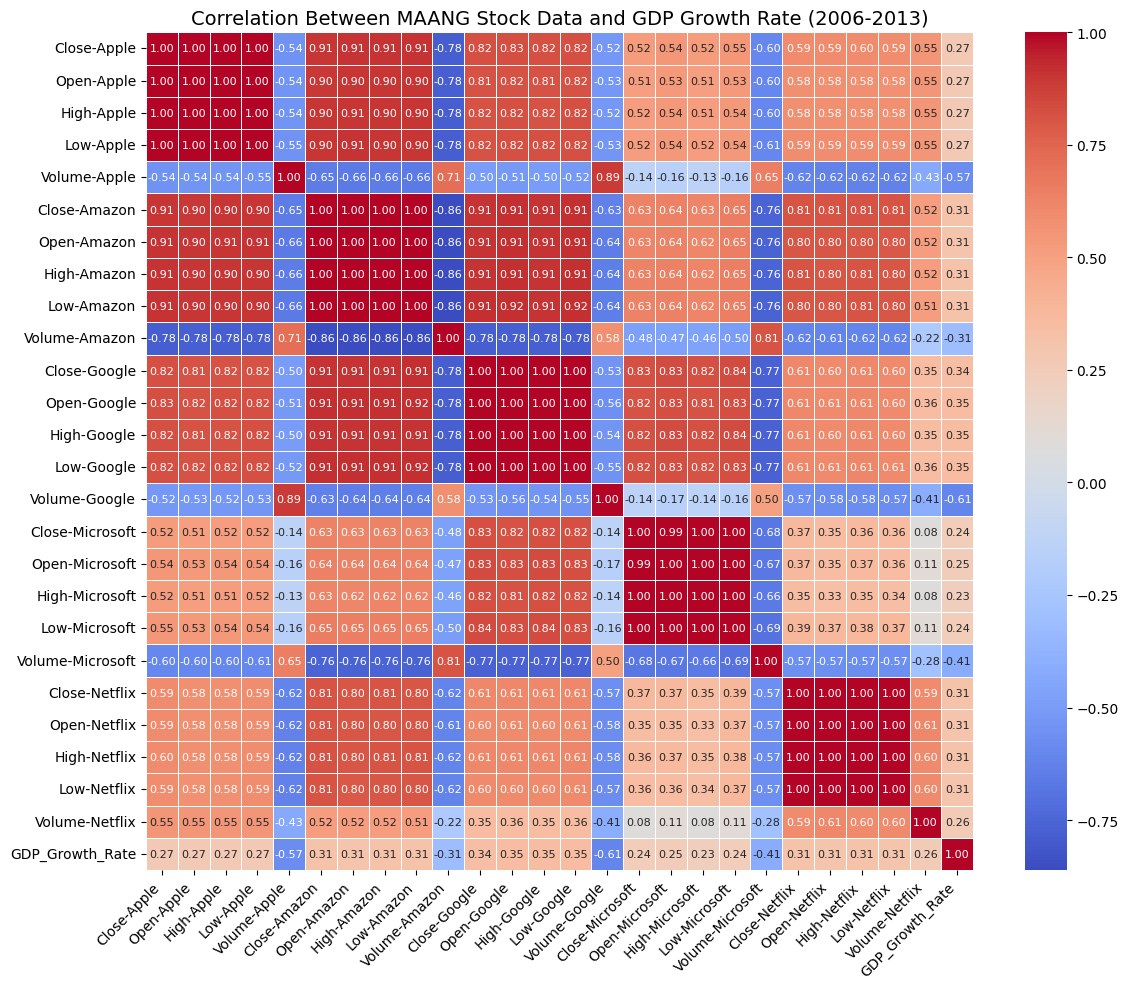

In [1]:
#Heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

apple_data = pd.read_csv('Apple.csv')
amazon_data = pd.read_csv('Amazon.csv')
google_data = pd.read_csv('Google.csv')
microsoft_data = pd.read_csv('Microsoft.csv')
netflix_data = pd.read_csv('Netflix.csv')

gdp_data = pd.read_csv('GDPC1.csv')
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
gdp_data['GDP_Growth_Rate'] = gdp_data['GDPC1'].pct_change() * 100
gdp_data = gdp_data[(gdp_data['DATE'] >= '2006-01-01') & (gdp_data['DATE'] <= '2013-12-31')]

def preprocess_data(data, company_name):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[(data['Date'] >= '2006-01-01') & (data['Date'] <= '2013-12-31')]
    data = data[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]
    data.columns = [f'{col}-{company_name}' if col != 'Date' else 'Date' for col in data.columns]
    return data

apple_data = preprocess_data(apple_data, 'Apple')
amazon_data = preprocess_data(amazon_data, 'Amazon')
google_data = preprocess_data(google_data, 'Google')
microsoft_data = preprocess_data(microsoft_data, 'Microsoft')
netflix_data = preprocess_data(netflix_data, 'Netflix')

merged_data = apple_data.merge(amazon_data, on='Date', how='inner') \
                        .merge(google_data, on='Date', how='inner') \
                        .merge(microsoft_data, on='Date', how='inner') \
                        .merge(netflix_data, on='Date', how='inner') \
                        .merge(gdp_data[['DATE', 'GDP_Growth_Rate']], left_on='Date', right_on='DATE', how='inner') \
                        .drop(columns=['DATE'])

data_for_heatmap = merged_data[['Close-Apple', 'Open-Apple', 'High-Apple', 'Low-Apple', 'Volume-Apple',
                                'Close-Amazon', 'Open-Amazon', 'High-Amazon', 'Low-Amazon', 'Volume-Amazon',
                                'Close-Google', 'Open-Google', 'High-Google', 'Low-Google', 'Volume-Google',
                                'Close-Microsoft', 'Open-Microsoft', 'High-Microsoft', 'Low-Microsoft', 'Volume-Microsoft',
                                'Close-Netflix', 'Open-Netflix', 'High-Netflix', 'Low-Netflix', 'Volume-Netflix',
                                'GDP_Growth_Rate']]
correlation_matrix = data_for_heatmap.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    annot_kws={"size": 8},
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

plt.title("Correlation Between MAANG Stock Data and GDP Growth Rate (2006-2013)", fontsize=14)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()